<a href="https://colab.research.google.com/github/marcelorandolfo/data-science/blob/master/deteccao_de_fraude_em_cartoes_de_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

Segundo o [Estadão](https://economia.estadao.com.br/noticias/geral,fraudes-em-cartao-de-credito-ja-passam-de-920-mil-no-pais-desde-o-inicio-do-ano,70002517637), no Brasil, entre janeiro e agosto de 2018, foram detectados 920 mil golpes com o objetivo de roubar informações pessoais de consumidores. Com essas informações, os criminosos conseguiam clonar os cartões de crédito das pessoas. A fraude mais popular é feita pelo teste do cartão, onde os criminosos testam a validade do cartão em sites de compras, e caso o cartão não esteja bloqueado ou sem limite, ele é utilizado em várias compras de pequeno valor.

Qualquer fraude em cartões de crédito é um risco de negócio para as operadoras do cartão, ou seja, se um consumidor detectar que houve uma fraude em seu cartão, é responsabilidade da empresa estornar esse valor integralmente ao consumidor. Sendo assim, a operadora de cartão tem que detectar se uma transação é fraude ou não antes que ela aconteça, para que não tenha que arcar com esse custo futuramente.

<center><img src='https://raw.githubusercontent.com/marcelorandolfo/data-science/master/images/fraudes_cartoes.jpg'width='500px'></center>

Para que isso possa ser feito, as empresas tem cada vez mais investido em modelos de *Machine Learning* para detectar se determinada compra é fraudulenta no momento em que está sendo feita. O modelo de *ML* analisa os comportamentos do consumidor, como valor, horário e local das compras, e define se aquela operação é válida ou não. Se for detectada uma fraude, essa compra é recusada.

Se o modelo identificar corretamente uma compra como fraudulente ou não, ótimo. O problema está nos falsos positivos ou falsos negativos. Um **falso negativo** ocorre quando o modelo identifica a compra como normal mas na verdade ela é um fraude. Nessa situação a empresa é penalizada e deve arcar com esse custo. Um **falso positivo** ocorre quando o modelo identifica a compra como fraude mas na verdade é uma compra normal. Nessa situação o consumidor é penalizado, pois não consegue realizar sua compra. Mas para a empresa o falso positivo também é ruim, pois o dono do cartão de crédito pode não gostar de ter sua compra recusada e deixar de ser cliente.

Com isso, os modelos de *Machine Learning* devem ser cada vez melhores, tendo uma boa acurácia na detecção de ambas as situações, se a compra é ou não uma fraude, minimizando situações de falsos negativos ou falsos positivos.

<center><img src='https://raw.githubusercontent.com/marcelorandolfo/data-science/master/images/fraudes_cartoes_ml.png'width='550px'></center>

O objetivo desse *notebook* é propor um modelo de *ML* para detecção de fraude em cartões de crédito. O modelo deve ser capaz de detectar bem ambas as situações, e ter poucas situações de falsos negativos ou positivos. 



## Importando os Dados

Os dados que serão utilizados na construção do modelo de *Machine Learning* foram obtidos no [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). Porém, a fonte primária dos dados é a *Université Libre de Bruxelles*, através do *Worldline and the Machine Learning Group*.

O *dataset* tem informações sobre transações feitas no cartão de crédito em setembro de 2013 na Europa. Os dados são de dois dias de compras, onde foram detectadas 492 fraudes em mais de 284 mil operações.

Para cada compra registrada existem 31 atributos. Três deles são:

* `Time`: tempo decorrido desde a primeira transação registrada no *dataset*.
* `Amount`: valor da compra.
* `Class`: apresenta valor 0 quando a compra é normal e 1 quando é fraudulenta.

No caso, nossa variável alvo é a variável `Class`. Os demais 28 atributos são variáveis numéricas resultantes de uma transformação de *Principal Component Analysis - PCA*. Segundo o [Oper Data](https://operdata.com.br/blog/analise-de-componentes-principais/), o *PCA* é uma técnica de análise de inter-relações para um grande número de variáveis. O objetivo é reunir a informação contida em um grande número de variáveis em um conjunto menor, minimizando a perda de informação. No caso, os 28 atributos são os componentes principais obtido pelo *PCA*, e foram identificados como `V1`, `V2`, ... ,`V27`,`V28`. Por sigilo, os dados originais não foram disponibilizados.

Na própria descrição dos dados já é possível observar um problema: os dados estão muito desbalanceados. Das mais de 284 mil operações, somente 492 foram identificadas como sendo fraudes. Isso corresponde à aproximadamente **0,2%** das compras. Como dito anteriormente, um bom modelo de *Machine Learning* para detecção de fraudes em cartões de crédito deve ser capaz de identificar corretamente quando uma compra é normal e também quando é uma fraude. Com os dados desbalanceados, nosso modelo será muito bom em identificar compras normais, mas irá cometer muitos erros ao tentar identificar fraudes. Como já vimos que para a operadora de cartão de crédito não é bom cometer nenhum dos dois tipos de erros, falsos positivos e falsos negativos, devemos corrigir esse desbalanceamento.

In [0]:
#@title
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [103]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# estilo do notebook
sns.set()

# path do dataset
file_path = 'https://www.dropbox.com/s/v1lyqxezlh10ced/creditcard.csv?dl=1'

# importando os dados
df = pd.read_csv(file_path)

# visualizando cinco primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Tendo importado os dados, é interessante observar a composição do `DataFrame` antes das análises.

### Qual o tamanho do `DataFrame`?

In [104]:
print('Número de transações em cartões de crédito:\t {}'.format(df.shape[0]))
print('Número de atributos:\t {}'.format(df.shape[1]))

Número de transações em cartões de crédito:	 284807
Número de atributos:	 31


### Há valores ausentes?

In [105]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

É possível observar que no `DataFrame` não há valores ausentes. Logo, não é necessário realizar nenhum procedimento de correção antes das análises exploratórias.

### Desbalanceamento da variável `Class`

0    284315
1       492
Name: Class, dtype: int64

0.17% das transações feitas no cartão de crédito são fraudulentas.



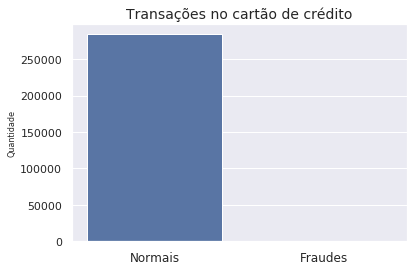

In [106]:
print(df['Class'].value_counts())
print('\n{0:.2f}% das transações feitas no cartão de crédito são fraudulentas.\n'.format((df[df['Class'] == 1].shape[0]/df.shape[0])*100))

# plotar gráfico
fig, ax = plt.subplots()

sns.countplot(x='Class', data=df, ax=ax)
ax.set_title('Transações no cartão de crédito', fontsize=14)
ax.set_xticklabels(['Normais','Fraudes'], fontsize = 12)
ax.set_ylabel('Quantidade', fontsize=8)
ax.set_xlabel('')

plt.plot();


Pelo gráfico é possível observar visualmente a disparidade entre compras normais e compras fraudulentas no `DataFrame`.

## Análise exploratória

In [107]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


No contexto atual, as estatísticas descritivas só fazem sentido para a variável `Amount`. A variável `Time` mede os segundos entre as transações, enquanto para a variável `Class` as estatísticas descritivas só nos mostra o que já tinha sido observado, que é o desbalanceamento dos dados. 

Para o montante das transações, podemos observar que:

* A média das transações realizadas no cartão de crédito é de aproximadamente 88 euros (não houve uma definição da unidade monetária da variável, mas como os dados são de transações feitas na Europa, supõe-se que a moeda utilizada seja o euro).
* A mediana das compras é de 22 euros, ou seja, o valor de metade das compras foi menor que 22 euros, e a outra metade foi maior que 22 euros.
* A maior compra realizada foi de aproximadamente 25000 euros.
* Por essas estatísticas é possível afirmar que há muitos valores considerados como *outliers* no *dataset*, onde esses valores altos nas compras tendem a elevar a média.
* Os valores iguais a 0 no `DataFrame` podem ser considerados como transações de teste de cartão.

Esses valores foram obtidos considerando os dados como um todo. Mas é interessante observar se há uma distinção pra quando a compra é normal ou fraude.



In [108]:
df[['Amount','Class']][df['Class'] == 0].describe()

,Amount,Class
count,284315.000000,284315.0
mean,88.291022,0.0
std,250.105092,0.0
min,0.000000,0.0
25%,5.650000,0.0
50%,22.000000,0.0
75%,77.050000,0.0
max,25691.160000,0.0


Para as compras consideradas como normais, temos que o comportamento é bem semelhante quando consideramos todos os dados. Dado que aproximadamente 99,8% dos dados são de transações normais, isso já era esperado.

In [109]:
df[['Amount','Class']][df['Class'] == 1].describe()

,Amount,Class
count,492.000000,492.0
mean,122.211321,1.0
std,256.683288,0.0
min,0.000000,1.0
25%,1.000000,1.0
50%,9.250000,1.0
75%,105.890000,1.0
max,2125.870000,1.0


Para as compras fraudulentas temos que:

* A média do valor é de aproximadamente 122 euros.
* Metade das compras fraudulentas teve um valor menor que 9 euros, enquanto a outra metade das compras foi de mais de 9 euros. Podemos concluir que a pessoa que comete uma fraude no cartão de crédito faz isso em compras de menor valor. Uma explicação possível para isso é que compras de menor valor tendem a não chamar muita atenção.
* Entretanto, o valor máximo de uma compra fraudulenta foi de mais de 2000 euros.

[]

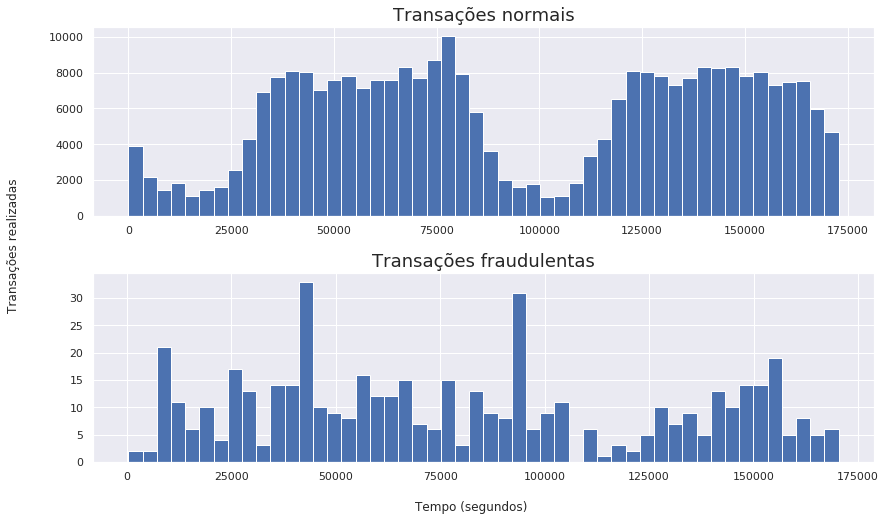

In [110]:
# histograma do tempo para transações normais e fraudes

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (14,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

bins = 50

ax[0].hist(df['Time'][df['Class'] == 0], bins=bins)
ax[0].set_title('Transações normais', fontsize = 18)

ax[1].hist(df['Time'][df['Class'] == 1], bins = bins)
ax[1].set_title('Transações fraudulentas', fontsize = 18)

fig.text(0.5, 0.04, 'Tempo (segundos)', ha='center')
fig.text(0.04, 0.5, 'Transações realizadas', va='center', rotation='vertical')

plt.plot()



Além da análise estatística descritiva, é interessante observar se o fato de uma compra ser normal ou ser fraudulenta altera o comportamento das demais demais variáveis. Como por exemplo, se há algum horario em que há menos compras normais e mais compras fraudulentas.

No imagem acima, temos dois histogramas para a variável `Time`, onde o primeiro considera somente as compras normais e o segundo somente as compras que são fraudes. Pelos histogramas não é possível observar um comportamento muito distinto quando consideramos os dados de forma separada.

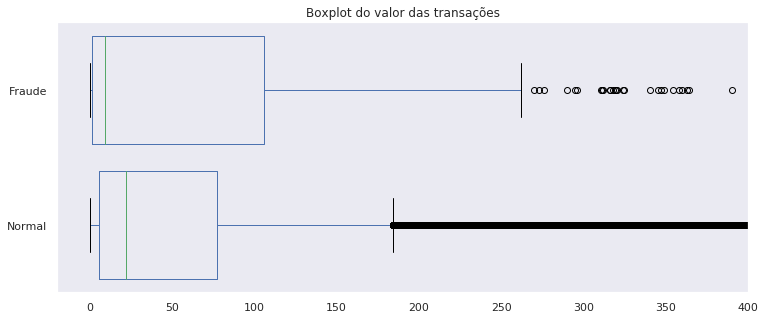

In [111]:
# boxplot de amount
fig, ax = plt.subplots(figsize = (12,5))

df.boxplot('Amount', widths=0.8, grid = False, by='Class', ax=ax, vert = False)
ax.set_yticklabels(['Normal','Fraude'])
plt.xlim((-20, 400))
ax.set_xlabel('')
ax.set_title('Boxplot do valor das transações', fontsize=12)
fig.suptitle('')

plt.show()

Para a variável `Amount` plotamos dois boxplots, o primeiro considera somente as compras fraudulentas e o segundo as compras normais. É possível analisar o que já tinha sido observado na análise estatística descritivas, compras fraudulentas estão mais concentradas em valores mais baixos. Entretanto, ainda há algumas compras fraudulentas que são de valores mais altos.

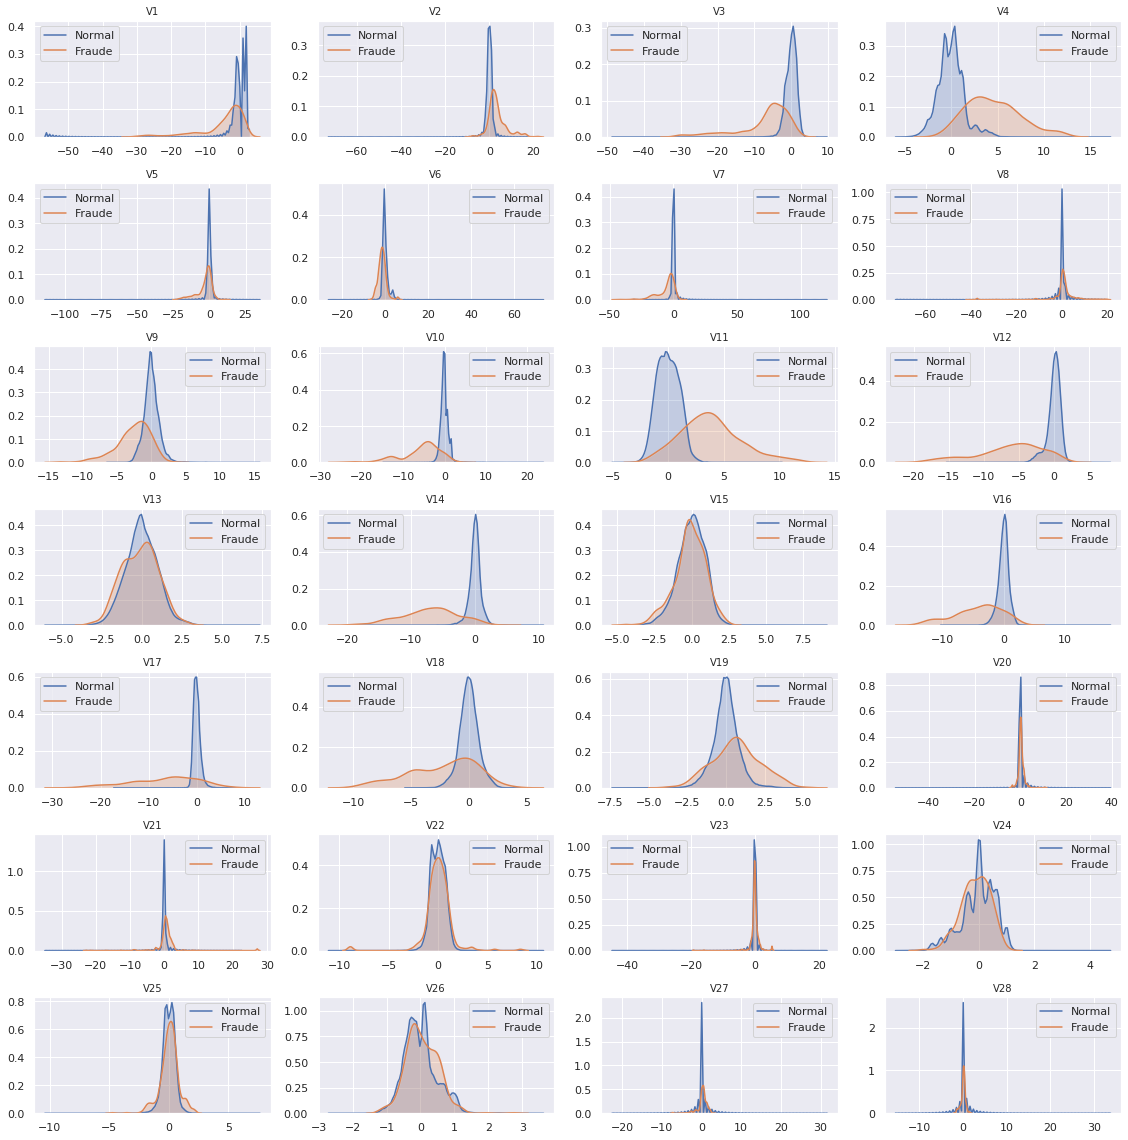

In [112]:
# densidade das variáveis PCA
colunas = df.drop(['Time', 'Amount','Class'], axis = 1).columns
df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

fig, ax = plt.subplots(nrows = 7, ncols = 4, figsize = (16,16))

idx = 0
for col in colunas:
  idx += 1
  plt.subplot(7, 4, idx)
  sns.kdeplot(df_class_0[col], label = 'Normal', shade = True)
  sns.kdeplot(df_class_1[col], label = 'Fraude', shade = True)
  plt.title(col, fontsize = 10)
plt.tight_layout()

Para observar a distinção das variáveis transformadas por *PCA* quando as compras são normais e quando são fraudulentas, temos os gráficos de de densidade da distribuição para cada um dos 28 atributos. Gráficos de densidade da distribuição nos mostra o *range* dos valores da variável e também sua frequência.

Pelos gráficos é possível observar que:

* Para os componentes principais `v1`, `v5`, `v6`, `v7`, `v8`, `v13`, `v15`, `v20`, `v21`, `v22`, `v23`, `v24`, `v25`, `v26`, `v27` e `v28` não há distinção no comportamento quando se separa os dados em relação a compra ser ou não uma fruade.
* Entretanto, para os componentes `v2`, `v3`, `v4`, `v9`, `v10`, `v11`, `v12`, `v14`, `v16`, `v17`, `v18` e `v19` é possível observar que o comportamento muda quando consideramos compras normais e compras fraudulentas separadamente.

## Prepração dos dados

Tendo feito a análise exploratória dos dados, temos que preparar os dados antes de estimarmos o modelo de *Machine Learning*. Serão feitas três etapas de tratamento nos dados: normalização, separação do *dataset* em treino e teste e balanceamento dos dados.

### Normalização

A primeira mudança feita será normalizar as variáveis `Time` e `Amount`. O objetivo com a normalização é deixar as variáveis com a mesma ordem de grandeza, além de reduzir o desvio padrão da variável. A normalização será feita através da função `StandardScaler`, mas basicamente a função aplica nos valores a seguinte fórmula:

\begin{equation}
z_{i}\; =\; \frac{x_{i} - \mu}{\sigma}
\end{equation}

Onde $z_{i}$ é o valor normalizado, $\;x_{i}$ é o valor original, $\;\mu$ é a média e $\;\sigma$ é o desvio padrão. No caso, a variável normalizada passa a ser medida por desvios em torno da média.  

In [113]:
from sklearn.preprocessing import StandardScaler

# criando cópia do dataframe
df_norm = df.copy()

# normalizando time e amount
std = StandardScaler()
df_norm['norm_time'] = std.fit_transform(df['Time'].values.reshape(-1,1))
df_norm['norm_amount'] = std.fit_transform(df['Amount'].values.reshape(-1,1))

# excluindo time e amount originais
df_norm.drop(['Time','Amount'], axis = 1, inplace = True)

# observando as cinco primeiras entradas
df_norm.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,norm_time,norm_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403


### Criar conjunto de treino e teste

A divisão dos dados em um conjunto de treino e outro de teste é uma prática comum em modelos de *Machine Learning*. O objetivo é utilizar parte dos dados para treinar o modelo e após o treino, testar se o modelo é adequado utilizando os dados de teste. A função utilizada é a `train_test_split` e os parâmetros utilizados são `stratify`, `shuffle` e `random_state`. O primeiro mantém a mesma proporção de valores para as categórias da variável alvo, ou seja, no conjunto de treino e teste haverá a mesma proporção de compras fraudulentas em relação ao total de compras. O segundo parâmetro mistura as entradas antes de dividir o *dataset*. Por sua vez, o último parâmetro garante que em toda vez que a divisão for feita, as mesmas entradas serão incluídas no conjunto de treino e de teste. O objetivo é garantir que o modelo seja sempre o mesmo.

A divisão será feita considerando os dados originais e os dados normalizados. O intuito é observar se há um ganho ao treinar o modelo com dados normalizados.

In [0]:
# pacote
from sklearn.model_selection import train_test_split

# dataset treino e teste - dados normais e dados normalizados

X = df.drop('Class', axis = 1)
y = df['Class']

X_n = df_norm.drop('Class', axis = 1)
y_n = df_norm['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle = True, random_state = 50)
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n, y_n, stratify=y, shuffle = True, random_state = 50)

Só para garantir que nossos *datasets* de treino e de teste tem a mesma proporção de compras que são fraudes:

In [115]:
print('Dados originais:\n Proporção de compras que são fraudes no dataset de treino: {0:.2f}%'.format((y_train.value_counts()[1]/y_train.shape[0])*100))
print(' Proporção de compras que são fraudes no dataset de teste: {0:.2f}%'.format((y_test.value_counts()[1]/y_test.shape[0])*100))
print('\nDados normalizados:\n Proporção de compras que são fraudes no dataset de treino: {0:.2f}%'.format((y_n_train.value_counts()[1]/y_n_train.shape[0])*100))
print(' Proporção de compras que são fraudes no dataset de teste: {0:.2f}%'.format((y_n_test.value_counts()[1]/y_n_test.shape[0])*100))

Dados originais:
 Proporção de compras que são fraudes no dataset de treino: 0.17%
 Proporção de compras que são fraudes no dataset de teste: 0.17%

Dados normalizados:
 Proporção de compras que são fraudes no dataset de treino: 0.17%
 Proporção de compras que são fraudes no dataset de teste: 0.17%


### Balanceamento dos dados

Por fim, o último procedimento a ser adotado é balancear os dados. No caso, iremos balancear nossos *datasets* de treino, tanto para os dados originais, quanto para os dados normalizados.

Existem dois métodos para balancear os dados. O primeiro é o `over_sampling`, onde se cria novas observações para a categoria minoritária utilizando as informações contidas nos dados originais, até que o número de ocorrências para ambas as categorias seja a mesma. O segundo método é o `under_sampling`, em que se exclui aleatoriamente observações da categoria majoritária, até que o número de ocorrências para as duas categorias seja a mesma. Ambos os métodos possui seus prós e contras, mas dado que o desbalanceamento é tão elevado, criar novas observações pode comprometer a qualidade do modelo, dado que a maioria das informações serão artificias.

Nesse caso, para o balanceamento iremos usar a biblioteca `imblearn` e o método será o `under_sampling`.

In [116]:
# pacote
from imblearn.under_sampling import RandomUnderSampler

# balanceando
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)
X_n_rus, y_n_rus = rus.fit_sample(X_n_train, y_n_train)

# verificando valores
print('Dados originais:\n Compras fraudulentas: {} \n Compras normais: {}'.format(pd.Series(y_rus).value_counts()[0],pd.Series(y_rus).value_counts()[1]))
print('\nDados normalizados:\n Compras fraudulentas: {} \n Compras normais: {}'.format(pd.Series(y_n_rus).value_counts()[0],pd.Series(y_n_rus).value_counts()[1]))

Dados originais:
 Compras fraudulentas: 369 
 Compras normais: 369

Dados normalizados:
 Compras fraudulentas: 369 
 Compras normais: 369


Lembrando que ao excluir as entradas de compras normais para balancear os dados, perdemos informações também nos *datasets* de variáveis explicativas.

In [117]:
# verificando valores
print('Dados originais:\n Número de transações registradas: {} \n Número de variáveis: {}'.format(X_rus.shape[0],X_rus.shape[1]))
print('\nDados normalizados:\n Número de transações registradas: {} \n Número de variáveis: {}'.format(X_n_rus.shape[0],X_n_rus.shape[1]))

Dados originais:
 Número de transações registradas: 738 
 Número de variáveis: 30

Dados normalizados:
 Número de transações registradas: 738 
 Número de variáveis: 30


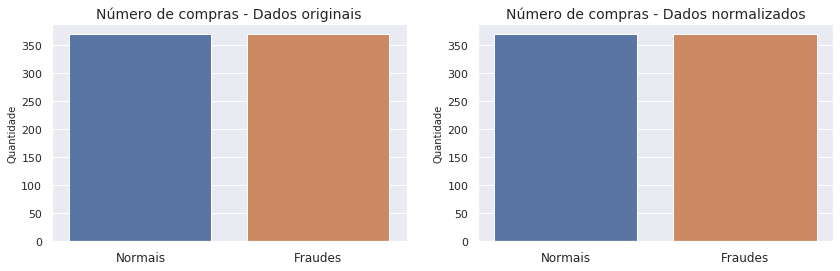

In [118]:
# plotar a nova distribuição de classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

sns.countplot(y_rus, ax=ax[0])
ax[0].set_title('Número de compras - Dados originais', fontsize=14)
ax[0].set_xticklabels(['Normais','Fraudes'], fontsize = 12)
ax[0].set_ylabel('Quantidade', fontsize=10)
ax[0].set_xlabel('')

sns.countplot(y_n_rus, ax=ax[1])
ax[1].set_title('Número de compras - Dados normalizados', fontsize=14)
ax[1].set_xticklabels(['Normais','Fraudes'], fontsize = 12)
ax[1].set_ylabel('Quantidade', fontsize=10)
ax[1].set_xlabel('')


plt.plot();

Agora os *datasets* estão balanceados, temos o mesmo número de ocorrências de compras normais e de compras que são fraudes. 

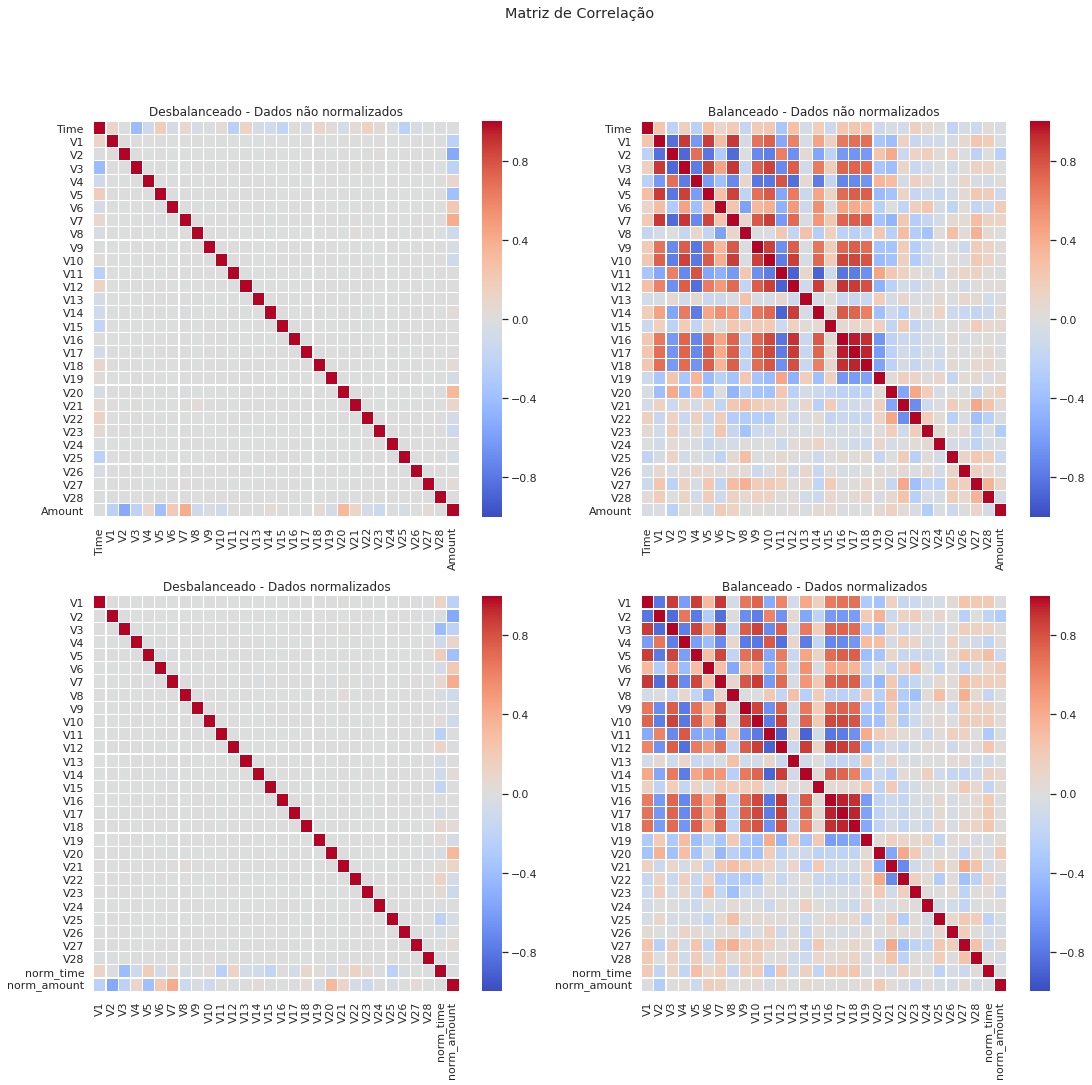

In [119]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()

corr_n = X_n_train.corr()
corr_rus_n = pd.DataFrame(X_n_rus).corr()


fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (18,16))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1.00, vmax= 1.00,
            linewidths=.1, cmap="coolwarm", ax=ax[0,0])
ax[0,0].set_title('Desbalanceado - Dados não normalizados')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1.00, vmax= 1.00,
            linewidths=.1, cmap="coolwarm", ax=ax[0,1])
ax[0,1].set_title('Balanceado - Dados não normalizados')

sns.heatmap(corr_n, xticklabels=corr_n.columns, yticklabels=corr_n.columns, vmin=-1.00, vmax= 1.00,
            linewidths=.1, cmap="coolwarm", ax=ax[1,0])
ax[1,0].set_title('Desbalanceado - Dados normalizados')

sns.heatmap(corr_rus_n, xticklabels=corr_n.columns, yticklabels=corr_n.columns, vmin=-1.00, vmax= 1.00,
            linewidths=.1, cmap="coolwarm", ax=ax[1,1])
ax[1,1].set_title('Balanceado - Dados normalizados')

plt.show()

Analisando a matriz de correlação é possível observar o quanto balancear os dados torna as correlações entre as variáveis explicativas mais perceptíveis no *heatmap*. Por sua vez, a normalização dos dados não trouxe um ganho nítido na exposição das correlações entre as variáveis.

## Modelo de Machine Learning

No nosso modelo de detecção de fraude em cartão de crédito usaremos como método uma regressão logística, dado que nossa variável alvo é um variável de classificação. O objetivo é identificar se uma transação no cartão de crédito é uma compra normal ou uma compra fraudulenta.

Além de esperar que o modelo seja adequado para prever corretamente a ocorrência das duas situações, espera-se que ele também apresente poucos falsos positivos e negativos. Falsos positivos são ruins para as operadoras de cartão porque impossibilitam o cliente de realizar sua compra, e falsos negativos são ruins porque aumentam os gastos que a operadora de cartão deve ter para ressarcir o cliente do valor da compra fraudulenta.

Como forma de comparação, iremos estimar quatro modelos. Primeiro com dados desbalanceados, sem e com a normalização, e depois com dados balanceados, sem e com a normalização de `Time` e `Amount`. Para determinar a qualidade do modelo iremos utilizar as seguintes métricas: acurácia, precisão, recall, área sob a curva ROC e matriz de confusão.

In [0]:
# instalar a biblioteca scikit-plot
!pip install -q scikit-plot

In [0]:
# pacotes do modelo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import scikitplot as skplt

### Dados desbalanceados

#### Dados não normalizados

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.9993    0.9996    0.9994     71079
           1     0.7200    0.5854    0.6457       123

    accuracy                         0.9989     71202
   macro avg     0.8596    0.7925    0.8226     71202
weighted avg     0.9988    0.9989    0.9988     71202

Acurácia:	 0.9989

AUC:	 0.9338



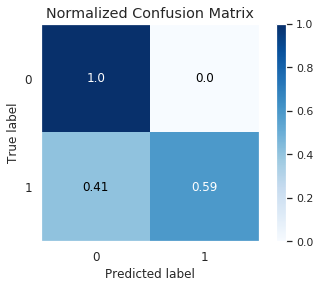

In [122]:
# instanciando e treinando o modelo
model_d = LogisticRegression()
model_d.fit(X_train, y_train)

# fazendo previsões
y_d_pred = model_d.predict(X_test)
y_d_proba = model_d.predict_proba(X_test)

# relatório do modelo
print('Relatório de classificação:\n', classification_report(y_test,y_d_pred, digits=4))

# acurácia do modelo
print('Acurácia:\t {:.4f}\n'.format(accuracy_score(y_test,y_d_pred)))

# AUC
print('AUC:\t {:.4f}\n'.format(roc_auc_score(y_test, y_d_proba[:,1])))

# matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test,y_d_pred, normalize=True);

Considerando os dados desbalanceados e não normalizados, temos que nosso modeço apresenta uma acurácia de 99,89%. Se fossemos considerar somente essa métrica de avaliação do modelo, iríamos concluir que nosso modelo é excelente. Porém, devemos nos atentar as demais métricas.

A precisão de um modelo de classificação mede a proporção de previsões corretas de uma categoria em relação as previsões dessa mesma categoria, certas e erradas. No nosso caso, a precisão do nosso modelo para a categoria 0, compra normal, é de 99,9%, ou seja, houveram pouquíssimas situações em que o modelo previu que uma compra era normal mas na verdade era uma compra fraudulenta.

Mas para compras que são fraudes nosso modelo teve uma precisão de 72%. Se fossemos utilizar esse modelo para fraudes em cartões de crédito **proporcionalmente** teríamos um número  consideravel de falsos positivos, ou seja, vários clientes teriam suas compras bloqueadas de forma errada.

Para a métrica de recall temos que para compras normais o valor também foi de 99,6%. O recall mede a proporção de previsões corretas de uma categoria em relação as previsões corretas mais as previsões para essa categoria que o modelo não conseguiu prever. 

Para compras que são fraudes o recall foi de 58,5%, ou seja, **proporcionalmente** houveram diversas compras fraudulentas que o modelo não conseguiu prever. Essa situação iria gerar um volume muito alto de gastos das operadores de cartão de crédito no ressarcimento do valor das compras para os clientes.

Na matriz de confusão podemos observar a métrica do recall de forma visual. O primeiro quadrado nos mostra a proporção de casos da categoria 0 que foram previsas como sendo 0, enquanto o segundo quadro nos mostra a proporção de casos em que a categoria era 0 mas foi prevista como 1. O terceiro quadrado nos mostra a proporção de casos da categoria 1 que foram previstas como 0, enquanto o último quadrado nos mostra a proporção de casos da categoria 1 previstos corretamente como sendo 1.

Por fim, a área sob a curva ROC foi de 0,9338. Utilizaremos esse valor para comparar a qualidade entre os modelos, dado que quanto maior de 1 for esse valor, mais bem ajustado é o modelo.



#### Dados normalizados

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.9994    0.9999    0.9996     71079
           1     0.9091    0.6504    0.7583       123

    accuracy                         0.9993     71202
   macro avg     0.9542    0.8251    0.8790     71202
weighted avg     0.9992    0.9993    0.9992     71202

Acurácia:	 0.9993

AUC:	 0.9753



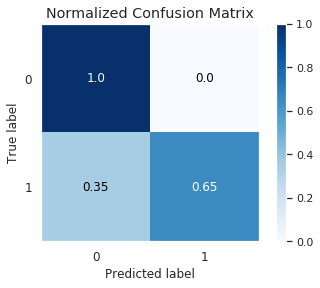

In [123]:
# instanciando e treinando o modelo
model_d_n = LogisticRegression()
model_d_n.fit(X_n_train, y_n_train)

# fazendo previsões
y_d_n_pred = model_d_n.predict(X_n_test)
y_d_n_proba = model_d_n.predict_proba(X_n_test)

# relatório do modelo
print('Relatório de classificação:\n', classification_report(y_n_test,y_d_n_pred, digits=4))

# acurácia do modelo
print('Acurácia:\t {:.4f}\n'.format(accuracy_score(y_n_test,y_d_n_pred)))

# AUC
print('AUC:\t {:.4f}\n'.format(roc_auc_score(y_n_test, y_d_n_proba[:,1])))

# matriz de confusão
skplt.metrics.plot_confusion_matrix(y_n_test,y_d_n_pred, normalize=True);


Considerando o modelo com as informações das variáveis `Time` e `Amount` normalizadas, temos que nosso modelo apresenta um ganho considerável na previsão de fraudes. A acurácia para a categoria 1 agora é de 90%, diminuindo o número de casos em que os clientes teriam suas compras bloqueadas. Enquanto isso, o recall do modelo é de 65%, diminuindo o gasto das operadoras de cartão de crédito em ressarcimento à clientes.

A área sob a curva ROC agora é de 0,9753, logo, para dados desbalanceados, o modelo com dados normalizados é mais bem ajustado.

### Dados balanceados

#### Dados não normalizados

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9739    0.9867     71079
           1     0.0565    0.9024    0.1063       123

    accuracy                         0.9738     71202
   macro avg     0.5282    0.9382    0.5465     71202
weighted avg     0.9982    0.9738    0.9852     71202

Acurácia:	 0.9738

AUC:	 0.9785



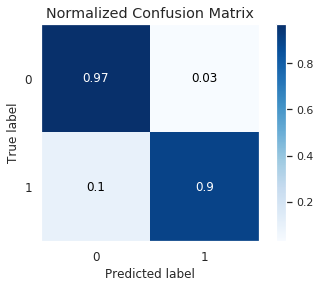

In [124]:
# instanciando e treinando o modelo
model = LogisticRegression()
model.fit(X_rus, y_rus)

# fazendo previsões
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# relatório do modelo
print('Relatório de classificação:\n', classification_report(y_test,y_pred, digits=4))

# acurácia do modelo
print('Acurácia:\t {:.4f}\n'.format(accuracy_score(y_test,y_pred)))

# AUC
print('AUC:\t {:.4f}\n'.format(roc_auc_score(y_test,y_proba[:,1])))

# matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True);

Agora com os dados balanceados podemos observar que a acurácia do nosso modelo diminuiu para 97,38%. O recall da categoria 0 agora é de 97,38%, ou seja, aumentaram os casos em que uma compra foi prevista como fraudulenta mas na verdade era uma compra normal. Isso pode ser observado na precisão do modelo para a categoria 1.

Em compensação, o recall do nosso modelo para a categoria 1 agora é de 90%, ou seja, as situações em que o modelo previu corretamente uma fraude aumentou bastante. Logo, os gastos das operadoras de cartão com o ressarcimento das compras iria diminuir muito ao utilizar um modelo que foi treinado com dados balanceados.

Com isso, é possível observar que ao diminuir os gastos da operadora de cartão de crédito no ressarcimento de compras fraudulentas, mais clientes acabariam tendo suas compras bloqueadas de forma incorreta.

Em relação à area sob a curva ROC, o modelo com dados balanceados mas não normalizados esse valor é de 0,9785.

#### Dados normalizados

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9719    0.9857     71079
           1     0.0527    0.9024    0.0996       123

    accuracy                         0.9718     71202
   macro avg     0.5263    0.9372    0.5426     71202
weighted avg     0.9982    0.9718    0.9841     71202

Acurácia:	 0.9718

AUC:	 0.9771



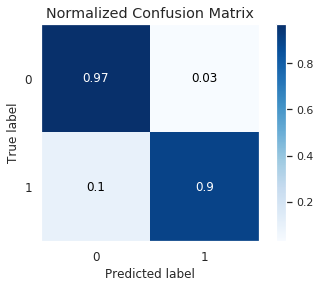

In [125]:
# instanciando e treinando o modelo
model_n = LogisticRegression()
model_n.fit(X_n_rus, y_n_rus)

# fazendo previsões
y_n_pred = model_n.predict(X_n_test)
y_n_proba = model_n.predict_proba(X_n_test)

# relatório do modelo
print('Relatório de classificação:\n', classification_report(y_n_test,y_n_pred, digits=4))

# acurácia do modelo
print('Acurácia:\t {:.4f}\n'.format(accuracy_score(y_n_test,y_n_pred)))

# AUC
print('AUC:\t {:.4f}\n'.format(roc_auc_score(y_n_test,y_n_proba[:,1])))

# matriz de confusão
skplt.metrics.plot_confusion_matrix(y_n_test, y_n_pred, normalize=True);

Observando as métricas para o modelo utilizando dados balanceados e normalizados temos que ele é menos ajustado que o modelo considerando os dados não normalizados. No caso, todas as métricas são melhores para o modelo anterior.

## Conclusão

De acordo com os modelos estimados podemos concluir que:

* Com dados desbalanceados os modelos estimados obtiveram um resultado muito bom para a previsão de compras que não eram fraudes. Esse resultado já era esperado, dado que o modelo foi treinado com um volume alto de situações de compras normais. Nesse caso, houveram poucas situações em que os clientes teriam suas compras bloqueadas de forma incorreta.
* Por outro lado, com dados desbalanceados o modelo não conseguia prever bem situações de fraudes. Isso acabaria por trazer prejuízos para as operadores de cartão de crédito na hora de ressarcir os clientes.
* Para dados desbalanceados, normalizar as variáveis `Time` e `Amount` melhorou a qualidade do modelo.
* Para dados balanceados, temos que os modelos diminuiram muito os casos em que as fraudes não eram percebidas. No caso, as operadores de cartão de crédito teriam menos gastos em ressarcimento de compras fraudulentas. Entretanto, o modelo passou a não prever tão bem compras normais, aumentando o número de casos em que os clientes teriam suas compras bloqueadas de forma errada.
* Para dados balanceados, a qualidade do modelo foi maior para as variáveis `Time` e `Amount` não normalizadas.

Considerando essas observações podemos notar um *trade-off*, ou nosso modelo gera um prejuízo maior para as operadores de cartão de crédito ou aumenta o número de vezes em que a compra de um cliente é bloqueada de forma incorreta. 

O modelo mais indicado será aquele mais alinhado aos valores da empresa. Digamos que para a empresa X o mais importante é o bem-estar do cliente. Logo, o modelo com dados desbalanceados seria melhor. Mas para uma empresa Y que tem como objetivo diminuir massivamente os gastos com ressarcimento, o modelo com dados balanceados é melhor.

No mundo real é mais fácil encontrar empresas Y. Mas isso não quer dizer que os clientes só têm a perder. Para contornar situações de bloqueio indevido de compras legítimas dos clientes, a operadora de cartão de crédito pode adotar uma verificação de duas etapas, em que uma mensagem é enviado para o celular do cliente para que ele confirme que realmente é ele que está realizando a compra. Pode ser adotado também um tipo de *cashback* para clientes que tiveram compras bloqueadas indevidamente.

No caso, é melhor utilizar um modelo que prevê bem as duas categorias do que um modelo que prevê uma categoria de forma muito boa, mas que é péssimo para prever a situação oposta.